## Preparation of FRP Observations for Wildfire Perimeters (2018-2023)

In this notebook, we gather and process fire radiative power (FRP) observations from both VIIRS and MODIS for wildfire events with at least 5% pre-fire quaking aspen forest cover in the western US. 

In [19]:
"""
Wildfire perimeters:
- Gather wildfire perimeters from FIRED (2018-2023) for the western US
- Calculate the LANDFIRE EVT (ca. 2016) categorical percentages
- Filter for wildfires where aspen cover >= 5%

Fire Radiative Power (FRP):
Read in the archived FRP data from the SUOMI VIIRS C2 (375m Obs.) as shapefile for the western U.S. (2018-2023)
Downloaded for western US from the LAADS archive: https://firms.modaps.eosdis.nasa.gov/download/
- Extract VIIRS observations within aspen wildfires
- Filter out low confidence observations
- Create the VIIRS "plot" using a square 375m buffer

Save these files out for further analysis and to ingest into Google Earth Engine

maxwell.cook@colorado.edu
"""

import os, time, glob
import numpy as np

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from rasterstats import zonal_stats

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Complete")

Complete


## Wrangle the Fire Data

First, we need to identify wildfire events across the western U.S. which had at least 5% pre-fire aspen cover. We start with a database of FIRED events extracted to western US states. We then calculate the zonal histogram from the LANDFIRE EVT (ca. 2016 remap). From there, we can identify wildfires with >5% aspen cover.

#### Step 1. Calculate LANDFIRE EVT cover type (%) for each fire

To start with, we will calculate the % cover for different land cover types within fire perimeters using FIRED and LANDFIRE EVT (ca. 2016 remap).

In [2]:
# Load the FIRED perimeters (2018-2022)
fired_path = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_events_west.gpkg')
fired = gpd.read_file(fired_path).to_crs(proj)
fired['ig_year'] = fired['ig_year'].astype(int)
fired = fired[(fired['ig_year'] >= 2018) & (fired['ig_year'] <= 2023)]

# Tidy some of the columns
fired = fired.rename(columns={'id': 'fired_id'})
fired['fired_id'] = fired['fired_id'].astype(str)
fired['ig_year'] = fired['ig_year'].astype(int)

print(f"Start year: {fired['ig_year'].min()}, end year:{fired['ig_year'].max()}")
print(f"There are {len(fired['fired_id'].unique())} unique fire events.")

2018, 2023
There are 8867 unique fire events.


In [3]:
# Load the LANDFIRE EVT (ca. 2016)
evt_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
evt = rxr.open_rasterio(evt_path, masked=True).squeeze()
shp, gt, wkt, nd = evt.shape, evt.spatial_ref.GeoTransform, evt.rio.crs, evt.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt[0].dtype}")

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


In [4]:
# Calculate the percent cover from the LANDFIRE EVT

t0 = time.time()

# Run the zonal statistics function (categorical raster data)
zs = zonal_stats(vectors=fired[['fired_id','geometry']], raster=evt_path, categorical=True, geojson_out=True)

# Extract the results as a geodataframe
stats = gpd.GeoDataFrame(zs).fillna(0) #One column per raster category, and pixel count as value

print(stats.head())
print(len(stats['id'].unique()))

del zs, evt, shp, gt, wkt, nd

print(f"Total elapsed time: {round((time.time() - t0))} seconds.")

Total elapsed time: 81 seconds.


In [6]:
# Explore the properties json

# First get the fired_id
stats['fired_id'] = stats['properties'].apply(lambda x: x.get('fired_id'))
# Retrieve the other properties (EVT codes)
stats['properties'] = stats['properties'].apply(lambda x: {key: val for key, val in x.items() if key != 'fired_id'})
stats['properties_list'] = stats['properties'].apply(lambda x: list(x.items()))

# Explode the json object
props = stats.explode('properties_list').reset_index(drop=True)
# retrieve the list items as new columns
props[['EVT', 'pixel_count']] = pd.DataFrame(props['properties_list'].tolist(), index=props.index)
props = props[['fired_id','EVT','pixel_count']].reset_index(drop=True)

# Calculate the percent of each class
total_pixels = props.groupby(props['fired_id'])['pixel_count'].transform('sum')
props['total_pixels'] = total_pixels
props['pct_cover'] = (props['pixel_count'] / props['total_pixels']) * 100

print(props.head())
print(props.columns)
print(len(props['fired_id'].unique()))

del stats, total_pixels

  fired_id   EVT  pixel_count  total_pixels  pct_cover
0       10  7035            1           242   0.413223
1       10  7037           99           242  40.909091
2       10  7039           81           242  33.471074
3       10  7043           54           242  22.314050
4       10  7063            2           242   0.826446
Index(['fired_id', 'EVT', 'pixel_count', 'total_pixels', 'pct_cover'], dtype='object')
8867


In [8]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')


In [9]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
# Merge back to the data
props_df = props.merge(lookup, left_on='EVT', right_on='VALUE', how='left')

print(props_df.head())
print(len(props_df['fired_id'].unique()))

del lookup

  fired_id   EVT  pixel_count  total_pixels  pct_cover  VALUE  \
0       10  7035            1           242   0.413223   7035   
1       10  7037           99           242  40.909091   7037   
2       10  7039           81           242  33.471074   7039   
3       10  7043           54           242  22.314050   7043   
4       10  7063            2           242   0.826446   7063   

                                            EVT_NAME  EVT_PHYS  \
0  North Pacific Dry Douglas-fir-(Madrone) Forest...   Conifer   
1  North Pacific Maritime Dry-Mesic Douglas-fir-W...   Conifer   
2  North Pacific Maritime Mesic-Wet Douglas-fir-W...   Conifer   
3    Mediterranean California Mixed Evergreen Forest   Conifer   
4           North Pacific Broadleaf Landslide Forest  Hardwood   

                                          EVT_GP_N           EVT_CLASS  
0                  Douglas-fir Forest and Woodland  Closed tree canopy  
1  Douglas-fir-Western Hemlock Forest and Woodland  Closed tree ca

### Step 2. Identify fires with at least 5% aspen forest cover

Now that we have a data frame of landcover types for each wildfire, we can isolate the quaking aspen cover types and identify wildfires which had at least 5% pre-fire aspen forest cover.

In [10]:
# Identify classes with 'aspen' in the EVT_NAME
aspen_evt = props_df[props_df['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(aspen_evt)

['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland'
 'Northwestern Great Plains Aspen Forest and Parkland']


In [11]:
# Now filter to retain wildfire events with at least 5% aspen forest cover
props_filtered = props_df[props_df['EVT_NAME'].isin(aspen_evt)]
aspen_sum = props_filtered.groupby('fired_id')['pct_cover'].sum().reset_index() # get the sum of aspen classes
aspen_sum['pct_aspen'] = aspen_sum['pct_cover']  # rename the column to retain aspen percent
aspen_fires = aspen_sum[aspen_sum['pct_aspen'] >= 5] # retain fires with >= 5% 
aspen_fires = aspen_fires[['fired_id','pct_aspen']] # subset columns
print(aspen_fires)

     fired_id  pct_aspen
7      189371  11.475541
14     189505  13.211368
15     189508  58.033241
16     189514  61.787865
17     189516  10.328717
...       ...        ...
1291    81343  24.608150
1292    81348   7.935393
1293    81355  10.354413
1297    82007   7.802875
1298    82031   6.261520

[420 rows x 2 columns]


In [13]:
# Join back to the FIRED data
# Check for matching fired_id set
common_ids = set(fired['fired_id']).intersection(set(aspen_fires['fired_id'])) # Find intersection
print(f"Number of common IDs: {len(common_ids)}")

# Join the attribute data to FIRED polygons
fired['fired_id'] = fired['fired_id'].astype(str)
aspen_fires['fired_id'] = aspen_fires['fired_id'].astype(str)

# Join aspen percent to the FIRED data
fired_aspen = pd.merge(fired, aspen_fires, on='fired_id', how='inner')
print(fired_aspen.columns)

# Save this file out
fired_aspen = fired_aspen.to_crs(proj)  # ensure the correct projection before exporting
fired_aspen.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_events_west_aspen_all_gt5pct.gpkg'))

Number of common IDs: 420
Index(['fired_id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2',
       'mu_grw_km2', 'mx_grw_dte', 'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code',
       'lc_mode', 'lc_name', 'lc_desc', 'lc_type', 'eco_mode', 'eco_name',
       'eco_type', 'tot_perim', 'geometry', 'pct_aspen'],
      dtype='object')


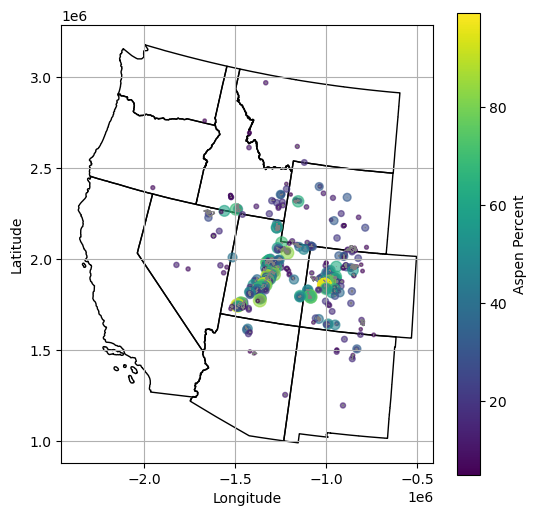

In [16]:
# Spatial map of aspen wildfires (centroid)

# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))

# Generate centroids
centroid = fired_aspen.copy()
centroid['geometry'] = centroid.geometry.centroid

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Plot centroids
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary
centroid.plot(
    ax=ax, markersize=centroid['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=True, alpha=0.6, 
    legend_kwds={'label': "Aspen Percent"})

# Optional: Plot the original fire perimeters for context
fired_aspen.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

del centroid

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Fig1_all_aspen_fires.png'), dpi=300, bbox_inches='tight')

plt.show()

#### Extract the daily fire perimeters for the aspen wildfire subset

We need to also extract the daily fire perimeters from FIRED so we can perform further analysis on the temporal patterns of fire growth as it relates to aspen cover, etc.

In [17]:
# Get the list of IDs
ids = aspen_fires['fired_id'].unique()

# Load the daily polygons, subset to aspen fires
daily_path = os.path.join(maindir,'FIRED/data/spatial/raw/events/events_040324/shapefiles/fired_conus_ak_2000_to_2024_daily.gpkg')
daily = gpd.read_file(daily_path)
daily['id'] = daily['id'].astype(str)
daily = daily[daily['id'].isin(ids)]
print(len(daily['id'].unique()))

# Save out
daily = daily.to_crs(proj)  # ensure the correct projection before exporting
daily.to_file(os.path.join(projdir,'data/spatial/mod/FIRED/fired_daily_west_aspen_all_gt5pct.gpkg'))

420


## Step 3. Wrangle the MODIS 1km and VIIRS 375m Active Fire Detections (AFD)

We downloaded the archive AFD for MODIS Collection 6.1 (1km), the Suomi National Polar-Orbiting Partnership (VIIRS S-NPP 375m) and NOAA-20 (VIIRS NOAA-20 375m) data products from the NASA FIRMS (https://firms.modaps.eosdis.nasa.gov/download/) between 2018-2023 in the western US. 

The VIIRS observations are split into archive (2018-2022) and "NRT" (2022-2023). These files need to be merged prior to performing the tidying.

To start with, we will create a tidy database of VIIRS observations for both the S-NPP and NOAA-20 vintages. Then, we will look at creating a combined dataset.

In [ ]:
t0 = time.time()

# Set up the file paths

modis = os.path.join(projdir,'data/spatial/raw/NASA-FIRMS/DL_FIRE_M-C61_476781/')
snpp = os.path.join(projdir,'data/spatial/raw/NASA-FIRMS/DL_FIRE_SV-C2_476784/')
noaa = os.path.join(projdir,'data/spatial/raw/NASA-FIRMS/DL_FIRE_J1V-C2_476782/')

# Store these in a dictionary
dict = {
    "MOD61": modis,
    "SNPP": snpp,
    "NOAA-20": noaa
}

# Process each of the archive data products
gdfs = {} # dictionary to store the geo data frames
for key, path in dict.items():
    print(f'Processing: {key}')
    # Read in the archive vector data
    vect = glob.glob(path+"*.shp")
    print([os.path.basename(v) for v in vect])
    if len(vect) > 1:
        print("~Merging archive and NRT data.")
        archive = gpd.read_file([v for v in vect if "archive" in v][0]).to_crs(proj)
        nrt = gpd.read_file([v for v in vect if "nrt" in v][0]).to_crs(proj)
        # Concatenate the archive and NRT
        afd = pd.concat([archive, nrt], ignore_index=True)
        del archive, nrt
    else:
        afd = gpd.read_file(vect[0]).to_crs(proj)

    # Add some attribute information
    afd['VID'] = afd.index # unique ID column

    # Remove low-confidence observations
    try:
        afd = afd[afd['CONFIDENCE'] != 'l']
    except KeyError as e:
        print(f"KeyError: {e}")

    del vect

    #################################################
    # Extract AFDs within wildfire data (aspen fires)
    # Buffer fire perimeters by 1km
    fire_buffer = fired_aspen.copy()
    fire_buffer['geometry'] = fire_buffer.geometry.buffer(1000)
    fire_buffer = fire_buffer[['fired_id','ig_date','last_date','geometry']] 
    # Extract AFDs
    afd_aspen = gpd.sjoin(afd, fire_buffer, how='inner', predicate='within')

    del fire_buffer
    
    ####################################################
    # Perform temporal filtering to remove false matches

    # First, create date columns
    afd_aspen['ACQ_DATE'] = pd.to_datetime(afd_aspen['ACQ_DATE'])
    afd_aspen['ACQ_MONTH'] = afd_aspen['ACQ_DATE'].dt.month.astype(int)
    afd_aspen['ACQ_YEAR'] = afd_aspen['ACQ_DATE'].dt.year.astype(int)
    afd_aspen['ig_date'] = pd.to_datetime(afd_aspen['ig_date'])
    afd_aspen['last_date'] = pd.to_datetime(afd_aspen['last_date'])

    # Filter based on ignition month and year
    afd_aspen_f = afd_aspen[
        (afd_aspen['ACQ_YEAR'] >= afd_aspen['ig_year']) & 
        (afd_aspen['ACQ_MONTH'] >= afd_aspen['ig_month']) &
        (afd_aspen['ACQ_YEAR'] <= afd_aspen['last_date'].dt.year) &
        (afd_aspen['ACQ_MONTH'] <= afd_aspen['last_date'].dt.month)
    ]
    
    # Keep unique rows
    afd_aspen_f = afd_aspen_f.drop_duplicates(subset='VID', keep='first')    
    print(f"Number of observations after filtering: {afd_aspen_f['VID'].nunique()}")
    print(f"Columns: \n {afd_aspen_f.columns()}")

    # Get a count per fire
    afd_counts = afd_aspen_f.groupby('fired_id').size().reset_index(name='counts')
    print(f"Minimum obs./fire: {afd_counts['counts'].min()}; \n Maximum obs./fire: {afd_counts['counts'].max()}")

    del afd_aspen
    
    #############################################
    # Remove fires with less than 10 observations

    # Get a list of IDs of fires with > 10 obs.
    ids = afd_counts[afd_counts["counts"] >= 10]
    # Grab the new list of unique FIRED ids
    ids = ids['fired_id'].unique().tolist()
    # Filter the datasets based on these FIRED ids
    afd_aspen_f = afd_aspen_f[afd_aspen_f['fired_id'].isin(ids)]
    fired_aspen_f = fired_aspen[fired_aspen['fired_id'].isin(ids)]
    
    print(f"Number of fires after filtering: {len(fired_aspen_f)}")
    print(f"Number of obs. after filtering: {len(afd_aspen_f)}")

    del afd_counts, ids
    
    #################################################
    # Plot the distribution of observations over time
    plt.figure(figsize=(6, 4))
    afd_aspen_f['ACQ_DATE'].hist(bins=100)
    plt.title(f'Number of Active Fire Detections Over Time ({key})')
    plt.xlabel('Date')
    plt.ylabel('Number of Observations')
    plt.tight_layout()
    plt.show()
    
    ##############################
    # Append to the new dictionary
    gdfs[key] = afd_aspen_f

print(f"Total elapsed time: {round((time.time() - t0))} seconds.")

Processing: MOD61
['fire_archive_M-C61_476781.shp']


In [ ]:
# Load the VIIRS archive shapefile
frp_archive = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/raw/VIIRS/DL_FIRE_SV-C2_438955/fire_archive_SV-C2_438955.shp')
frp_archive = gpd.read_file(frp_archive).to_crs(proj)
print(frp_archive.head())
print(frp_archive.columns)
len(frp_archive)

In [ ]:
# Load the VIIRS archive shapefile
frp_nrt = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/raw/VIIRS/DL_FIRE_SV-C2_438955/fire_nrt_SV-C2_438955.shp')
frp_nrt = gpd.read_file(frp_nrt).to_crs(proj)
print(frp_nrt.columns)
len(frp_nrt)

In [ ]:
# Merge the archive and NRT data
frp = pd.concat([frp_archive, frp_nrt], ignore_index=True)

# Add a unique ID column
frp['VID'] = frp.index
print(frp['VID'].nunique())

# Check the lastg date of observation
print(frp['ACQ_DATE'].max())

del frp_archive, frp_nrt  # clean up

In [ ]:
# Extract VIIRS obs. within aspen fires (1km buffer)
      
# Buffer the fires by 1km
fired_aspen_1km = fired_aspen.copy()
fired_aspen_1km['geometry'] = fired_aspen_1km.geometry.buffer(1000)

# Extract VIIRS obs.
frp_aspen = gpd.sjoin(frp, fired_aspen_1km, how='inner', predicate='within')

frp_aspen = frp_aspen[[
    'VID','LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'CONFIDENCE', 
    'FRP', 'DAYNIGHT', 'fired_id', 'ig_date', 'ig_day', 'ig_month', 
    'ig_year', 'last_date', 'event_dur', 'tot_ar_km2', 'fsr_km2_dy',
    'mx_grw_km2', 'mn_grw_km2','mu_grw_km2', 'mx_grw_dte', 'ig_utm_x', 'ig_utm_y',
    'tot_perim', 'pct_aspen', 'geometry']]

print(frp_aspen.head())
print(len(frp_aspen))
print(frp_aspen['VID'].nunique())
print(frp_aspen['fired_id'].nunique())

In [ ]:
# Only keep nominal and high confidence observations
print(frp['CONFIDENCE'].unique())

# Filter out low confidence observations
frp_aspen = frp_aspen[frp_aspen['CONFIDENCE'] != 'l']

print(f"Number of observations of nominal to high confidence: {len(frp_aspen)}")

In [ ]:
# Get a count of observations per 'fired_id'
viirs_counts = frp_aspen.groupby('fired_id').size().reset_index(name='counts')
print(viirs_counts['counts'].min())
print(viirs_counts['counts'].max())

# Plot the histogram
plt.figure(figsize=(6, 3))
plt.hist(viirs_counts['counts'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of VIIRS Observations per Fire')
plt.xlabel('Number of VIIRS Observations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Tidy the FRP data: remove null values, check on the obs./fire, and check on date matches

Some observations may not be joined correctly (i.e., spatial overlap but wrong ignition year, etc). We may also have some fires with too few observations. 

In [ ]:
# Check on date matches (by year and/or month)
# Filter any observations that dont match the fire year

# First create a year/month column from the VIIRS acquisition date
frp_aspen['ACQ_DATE'] = pd.to_datetime(frp_aspen['ACQ_DATE'])
frp_aspen['ACQ_MONTH'] = frp_aspen['ACQ_DATE'].dt.month.astype(int)
frp_aspen['ACQ_YEAR'] = frp_aspen['ACQ_DATE'].dt.year.astype(int)
frp_aspen['last_date'] = pd.to_datetime(frp_aspen['last_date'])

print(frp_aspen['ACQ_YEAR'].min())
print(frp_aspen['ACQ_YEAR'].max())

# Count the number of VIIRS observations that do not match the ignition year
print(f"Number of VIIRS obs. that do not match the ignition year: {(frp_aspen['ACQ_YEAR'] != frp_aspen['ig_year']).sum()}")

# Filter based on ignition month and year
frp_aspen_f = frp_aspen[
    (frp_aspen['ACQ_YEAR'] >= frp_aspen['ig_year']) & 
    (frp_aspen['ACQ_MONTH'] >= frp_aspen['ig_month']) &
    (frp_aspen['ACQ_YEAR'] <= frp_aspen['last_date'].dt.year) &
    (frp_aspen['ACQ_MONTH'] <= frp_aspen['last_date'].dt.month)
]

# Keep unique rows
frp_aspen_f = frp_aspen_f.drop_duplicates(subset='VID', keep='first')
print(frp_aspen_f.columns)

# Filter out the VIIRS observations with different ignition years
# frp_aspen_f = frp_aspen[frp_aspen['ACQ_YEAR'] == frp_aspen['ig_year']]
print(len(frp_aspen_f))

print(frp_aspen_f['VID'].nunique())

viirs_counts = frp_aspen_f.groupby('fired_id').size().reset_index(name='counts')
print(viirs_counts['counts'].min())
print(viirs_counts['counts'].max())

In [ ]:
# Check on fires with < N observations
N = 10

# Get a count of observations per 'fired_id'
print(f'Number of fires with >= {str(N)} observations: {len(viirs_counts[viirs_counts["counts"] >= N])}')
print(f'Percent of events: {round(len(viirs_counts[viirs_counts["counts"] >= N]) / len(viirs_counts) * 100, 3)}')

# Filter out fires with less than 10 observations
ids = viirs_counts[viirs_counts["counts"] >= N]

# Grab the new list of unique FIRED ids
ids = ids['fired_id'].unique().tolist()

# Filter the datasets based on the FIRED ids
frp_aspen_f = frp_aspen_f[frp_aspen_f['fired_id'].isin(ids)]
fired_aspen = fired_aspen[fired_aspen['fired_id'].isin(ids)]

print(len(frp_aspen_f))
print(frp_aspen_f.columns)

viirs_counts_ = frp_aspen_f.groupby('fired_id').size().reset_index(name='counts')
print(f"Min obs: {viirs_counts_['counts'].min()}")
print(f"Max obs: {viirs_counts_['counts'].max()}")
print(frp_aspen_f.head())

In [ ]:
# Make a map of the fire with the most observations

# Sort the VIIRS counts
viirs_counts = viirs_counts.sort_values('counts', ascending=False).reset_index(drop=True)

# Take the first row (the maximum)
max_obs = viirs_counts.iloc[0]['fired_id']
print(max_obs)

# Filter the fire perimeter and VIIRS obs.
perim = fired_aspen[fired_aspen['fired_id'] == max_obs]
obs = frp_aspen_f[frp_aspen_f['fired_id'] == max_obs]
obs = obs.copy()
obs['FRP_log'] = np.log1p(obs['FRP'])
obs = obs[obs['DAYNIGHT'] == 'D']
print(len(obs))

# Create the map
fig, ax = plt.subplots(figsize=(4, 5.5))
# Plot VIIRS points
obs.plot(column='FRP_log', ax=ax, legend=True,
         legend_kwds={'label': "Fire Radiative Power (FRP)", 'orientation': "horizontal"},
         cmap='magma', markersize=1, alpha=0.7)
# Plot the fire perimeter
perim.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='Fire Perimeter')
plt.tight_layout()
plt.grid(True)

# Save the map as a PNG
plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_MullenFire_FRP.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
print(len(frp_aspen_f['pct_aspen']))
print(len(frp_aspen_f['FRP']))
      
# Scatterplot of FRP and aspen_pct (fire perimeter)
plt.figure(figsize=(6, 4))  # Set the figure size
plt.scatter(frp_aspen_f['pct_aspen'], frp_aspen_f['FRP'], alpha=0.5)  # Plot with some transparency

# Add titles and labels
plt.ylabel('Fire Radiative Power (FRP)')
plt.xlabel('Aspen %')

plt.show()

## Join VIIRS observations to daily FIRED perimeters

We want to summarize VIIRS observations on a daily basis and then associate them with the correct daily polygon from FIRED. The initial step is to group observations by day.



In [ ]:
# Create the daily summary of FRP for each wildfire event

## Create the VIIRS observation buffer (375m2)

The archive VIIRS data is distributed as shapefiles with centroids representing the pixel center of a VIIRS observation. In order to assess characteristics within the VIIRS observations, we want to create a 375m2 buffer around the centroid locations to approximate the VIIRS pixel size.

In [ ]:
# Create the buffered VIIRS obs.
frp_aspen_plot = frp_aspen_f.copy()
frp_aspen_plot['geometry'] = frp_aspen_plot.geometry.buffer(375, cap_style=3)  # square buffer 375m

print(len(fired_aspen))

# Let's plot one fire using the FRP column to color the "plots"

# Filter the fire perimeter and VIIRS obs.
perim = fired_aspen[fired_aspen['fired_id'] == "42306"]  # Williams Fork Fire "45811.0"
obs = frp_aspen_plot[frp_aspen_plot['fired_id'] == "42306"]
obs = obs.copy()
obs['FRP_log'] = np.log1p(obs['FRP'])
obs = obs[obs['DAYNIGHT'] == 'D']  # plot only daytime observations
print(len(obs))

# Create the map
fig, ax = plt.subplots(figsize=(4, 5.5))
# Plot VIIRS points
obs.plot(column='FRP_log', ax=ax, legend=True,
         legend_kwds={'label': "Fire Radiative Power (FRP)"},
         cmap='magma', markersize=1, alpha=0.7)
# Plot the fire perimeter
perim.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='Fire Perimeter')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
centroid = fired_aspen.copy()
centroid['geometry'] = centroid.geometry.centroid

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Plot centroids
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary
centroid.plot(
    ax=ax, markersize=centroid['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=True, alpha=0.6, 
    legend_kwds={'label': "Aspen Percent"})

# Optional: Plot the original fire perimeters for context
fired_aspen.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

del centroid

# Save the map as a PNG
plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/Fig1_aspen_fires.png'), dpi=300, bbox_inches='tight')

plt.show()

## Tidy and save out the necessary files

Now that we have a tidy dataframe for both wildfires with >=5% pre-fire aspen cover and their associated nominal or high confidence VIIRS observations, we can save these files out for further processing. 

Some of the processing will occur in GEE, so for these files we want to save a simplified SHP with only the required attribute information (they will be joined back to the full data after processing).

In [ ]:
# Check on the observation counts again
viirs_counts = frp_aspen_plot.groupby('fired_id').size().reset_index(name='counts')
print(viirs_counts['counts'].min())
print(viirs_counts['counts'].max())

In [ ]:
# Filter the daily files
# Get the list of IDs
ids = fired_aspen['fired_id'].unique()

# Load the daily polygons, subset to aspen fires
daily['id'] = daily['id'].astype(str)
daily = daily[daily['id'].isin(ids)]
print(len(daily['id'].unique()))

# Save the daily wildfire perimeters
daily = daily.to_crs(proj)  # ensure the correct projection before exporting
daily.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_daily_west_aspen.gpkg'))

In [ ]:
# Save the wildfire perimeters
fired_aspen = fired_aspen.to_crs(proj)  # ensure the correct projection before exporting
fired_aspen.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_events_west_aspen.gpkg'))

# Save the VIIRS observations (points)
frp_aspen_f = frp_aspen_f.to_crs(proj)
frp_aspen_f.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_obs_fired_events_west_aspen.gpkg'))

# Save the VIIRS observations (plots)
frp_aspen_plot = frp_aspen_plot.to_crs(proj)
frp_aspen_plot.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_plots_fired_events_west_aspen.gpkg'))

# Tidy the files for GEE imports

# FIRED perimeters (1km buffer)
print(fired_aspen_1km.columns)
fired_aspen_gee = fired_aspen_1km[['fired_id','ig_date','ig_year','last_date','mx_grw_dte','geometry']]
fired_aspen_gee['ig_date'] = fired_aspen_gee['ig_date'].astype(str)
fired_aspen_gee['last_date'] = fired_aspen_gee['ig_date'].astype(str)
fired_aspen_gee.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/GEE/fired_events_west_aspen.shp'))

# VIIRS "plots"
print(frp_aspen_plot.columns)
frp_aspen_gee = frp_aspen_plot[['fired_id','VID','ACQ_DATE','DAYNIGHT','geometry']]
frp_aspen_gee['ACQ_DATE'] = frp_aspen_gee['ACQ_DATE'].astype(str)
frp_aspen_gee.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/GEE/viirs_plots_fired_events_west_aspen.shp'))

print("Success!")